# Global Battery Comparison

This notebook compares **global** (full-range) metrics across all simulation JSON files in `out/simulation_json/config_*.json`.

Covered metrics:
- Injected energy impact
- Consumed energy impact
- Rentability
- Battery utilization
- Battery status distribution


In [1]:
import json
import pathlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from IPython.display import display

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlesize"] = 12

FILES = sorted(str(p) for p in pathlib.Path("out/simulation_json").glob("config_*.json"))
if not FILES:
    raise FileNotFoundError("No simulation JSON files found in out/simulation_json/config_*.json")

GLOBAL_FIG_DIR = pathlib.Path("out/global_images")
GLOBAL_FIG_DIR.mkdir(parents=True, exist_ok=True)


def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)


def export_current_figure(filename_stem):
    path = GLOBAL_FIG_DIR / f"{filename_stem}.png"
    plt.savefig(path, dpi=220, bbox_inches="tight")
    print(f"Saved figure: {path}")


In [2]:
rows = []
phases = ["A", "B", "C"]

for file in FILES:
    data = load_json(file)
    scenario = pathlib.Path(file).stem.replace("config_", "")

    cfg = data.get("configuration", {})
    battery_cfg = cfg.get("battery", {})
    capacity_per_phase = battery_cfg.get("capacity_Wh_per_phase", [0, 0, 0]) or [0, 0, 0]
    total_kwh = round(sum(capacity_per_phase) / 1000, 2)
    scenario_label = "noBattery" if total_kwh == 0 else f"{total_kwh:.2f} kWh"

    g = data.get("global", {})
    energy = g.get("energy", {})
    battery = g.get("battery", {})
    rent = g.get("rentability", {})

    injected = energy.get("injected", [])
    consumed = energy.get("consumed", [])

    injected_delta_kwh = sum(float(x.get("energy_kwh", 0) or 0) for x in injected)
    consumed_delta_kwh = sum(float(x.get("energy_kwh", 0) or 0) for x in consumed)

    # Convention in JSON is signed deltas vs no-battery baseline.
    # Negative kWh means reduction; we plot reductions as positive values.
    injected_reduction_kwh = -injected_delta_kwh
    consumed_reduction_kwh = -consumed_delta_kwh

    injected_impact_chf = sum(float(x.get("delta_chf", 0) or 0) for x in injected)
    consumed_impact_chf = sum(float(x.get("delta_chf", 0) or 0) for x in consumed)

    total_gain_chf = float(rent.get("total_gain_chf", 0) or 0)
    bill_without_battery_chf = float(rent.get("bill_without_battery_chf", 0) or 0)
    bill_with_battery_chf = float(rent.get("bill_with_battery_chf", 0) or 0)
    bill_reduction_chf = float(rent.get("bill_reduction_chf", total_gain_chf) or 0)
    bill_reduction_pct_vs_no_battery = rent.get("bill_reduction_pct_vs_no_battery", np.nan)
    bill_reduction_pct_vs_no_battery = (
        float(bill_reduction_pct_vs_no_battery)
        if bill_reduction_pct_vs_no_battery not in (None, "")
        else np.nan
    )
    grid_consumed_without_battery_kwh = float(rent.get("grid_consumed_without_battery_kwh", np.nan) or np.nan)
    grid_consumed_with_battery_kwh = float(rent.get("grid_consumed_with_battery_kwh", np.nan) or np.nan)
    grid_consumed_reduction_kwh_total = float(rent.get("grid_consumed_reduction_kwh", consumed_reduction_kwh) or 0)
    grid_consumed_reduction_pct_vs_no_battery = rent.get("grid_consumed_reduction_pct_vs_no_battery", np.nan)
    grid_consumed_reduction_pct_vs_no_battery = (
        float(grid_consumed_reduction_pct_vs_no_battery)
        if grid_consumed_reduction_pct_vs_no_battery not in (None, "")
        else np.nan
    )
    annualized_gain_chf = float(rent.get("annualized_gain_chf", 0) or 0)
    amortization_years = rent.get("amortization_years", np.nan)
    amortization_years = float(amortization_years) if amortization_years not in (None, "") else np.nan

    utilization = battery.get("utilization")
    if isinstance(utilization, dict):
        cycles_per_year = float(utilization.get("cycles_per_year", 0) or 0)
        pct_max_cycles = float(utilization.get("percent_of_max_cycles_per_year", 0) or 0)
    else:
        cycles_per_year = 0.0
        pct_max_cycles = 0.0

    status = battery.get("status", {})

    def avg_status_pct(key):
        values = []
        for phase in phases:
            values.append(float(status.get(phase, {}).get(key, {}).get("samples_percent", 0) or 0))
        return float(np.mean(values)) if values else 0.0

    rows.append(
        {
            "scenario": scenario,
            "scenario_label": scenario_label,
            "total_kwh": total_kwh,
            "injected_reduction_kwh": injected_reduction_kwh,
            "consumed_reduction_kwh": consumed_reduction_kwh,
            "injected_impact_chf": injected_impact_chf,
            "consumed_impact_chf": consumed_impact_chf,
            "total_gain_chf": total_gain_chf,
            "bill_without_battery_chf": bill_without_battery_chf,
            "bill_with_battery_chf": bill_with_battery_chf,
            "bill_reduction_chf": bill_reduction_chf,
            "bill_reduction_pct_vs_no_battery": bill_reduction_pct_vs_no_battery,
            "grid_consumed_without_battery_kwh": grid_consumed_without_battery_kwh,
            "grid_consumed_with_battery_kwh": grid_consumed_with_battery_kwh,
            "grid_consumed_reduction_kwh_total": grid_consumed_reduction_kwh_total,
            "grid_consumed_reduction_pct_vs_no_battery": grid_consumed_reduction_pct_vs_no_battery,
            "annualized_gain_chf": annualized_gain_chf,
            "amortization_years": amortization_years,
            "cycles_per_year": cycles_per_year,
            "pct_max_cycles": pct_max_cycles,
            "status_charging_pct": avg_status_pct("charging"),
            "status_discharging_pct": avg_status_pct("discharging"),
            "status_full_pct": avg_status_pct("full"),
            "status_empty_pct": avg_status_pct("empty"),
            "status_idle_pct": avg_status_pct("idle"),
        }
    )

df_global = pd.DataFrame(rows).sort_values(["total_kwh", "scenario"]).reset_index(drop=True)

display(
    df_global[
        [
            "scenario",
            "scenario_label",
            "injected_reduction_kwh",
            "consumed_reduction_kwh",
            "total_gain_chf",
            "annualized_gain_chf",
            "amortization_years",
            "cycles_per_year",
            "pct_max_cycles",
        ]
    ].style.format(
        {
            "injected_reduction_kwh": "{:.1f}",
            "consumed_reduction_kwh": "{:.1f}",
            "total_gain_chf": "{:.2f}",
            "annualized_gain_chf": "{:.2f}",
            "amortization_years": "{:.2f}",
            "cycles_per_year": "{:.1f}",
            "pct_max_cycles": "{:.2f}",
        }
    )
)


,scenario,scenario_label,injected_reduction_kwh,consumed_reduction_kwh,total_gain_chf,annualized_gain_chf,amortization_years,cycles_per_year,pct_max_cycles
0,Zendure2400_noBattery,noBattery,-0.0,-0.0,0.00,0.00,nan,0.0,0.00
1,Zendure2400_2880Wh,8.64 kWh,2614.3,1869.5,478.77,478.93,6.35,258.7,4.31
2,Zendure2400_2880kwh,8.64 kWh,2477.1,2009.2,534.50,534.68,5.69,258.8,4.31
3,Zendure2400_5760Wh,17.28 kWh,3826.3,2740.4,702.16,702.40,6.64,189.7,3.16
4,Zendure2400_5760kwh,17.28 kWh,3581.5,2910.3,774.63,774.89,6.02,187.5,3.13
5,Zendure2400_8640Wh,25.92 kWh,4347.3,3119.5,799.78,800.05,8.09,143.9,2.40
6,Zendure2400_8640kwh,25.92 kWh,4051.9,3298.9,878.50,878.80,7.36,141.6,2.36
7,Zendure2400_11520Wh,34.56 kWh,4587.6,3297.4,845.87,846.16,9.75,114.0,1.90
8,Zendure2400_11520kwh,34.56 kWh,4267.6,3480.4,927.28,927.60,8.90,112.0,1.87
9,Zendure2400_14400Wh,43.20 kWh,4727.6,3403.7,873.61,873.91,11.43,94.0,1.57


Saved figure: out/global_images/01_global_energy_reduction_kwh.png


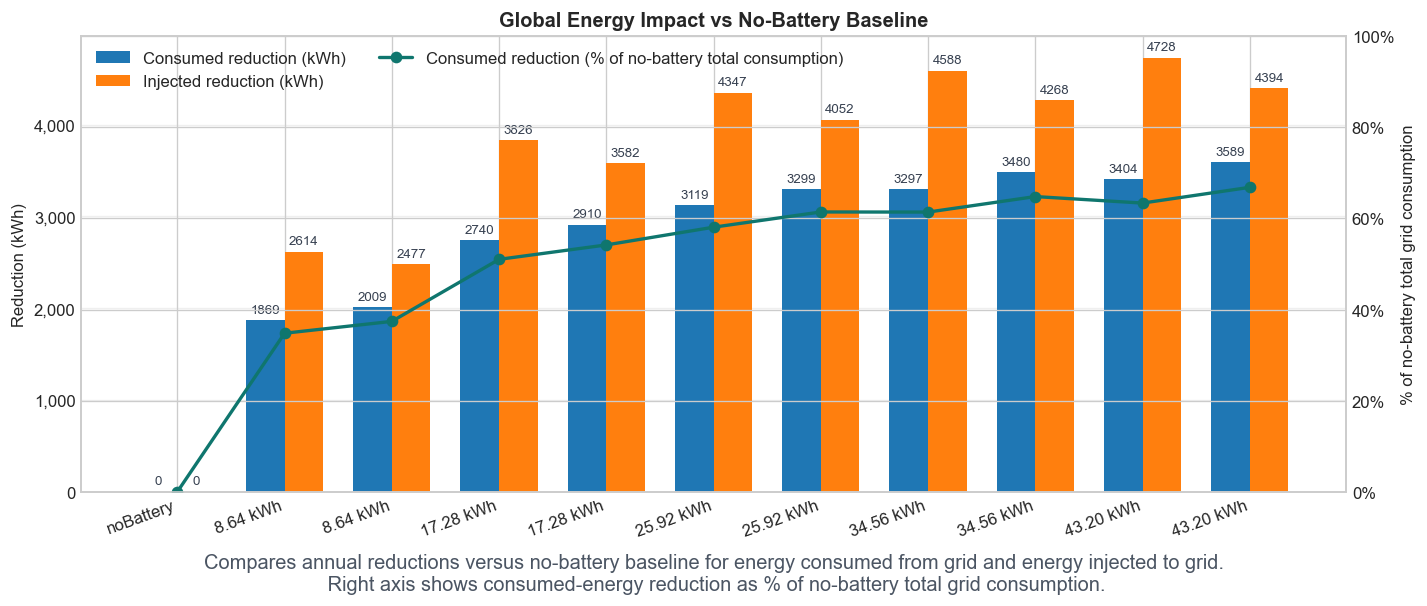

In [3]:
plot_df = df_global.copy()
x = np.arange(len(plot_df))
width = 0.36

fig, ax = plt.subplots(figsize=(12, 5))
bars1 = ax.bar(
    x - width / 2,
    plot_df["consumed_reduction_kwh"],
    width,
    label="Consumed reduction (kWh)",
    color="#1f77b4",
)
bars2 = ax.bar(
    x + width / 2,
    plot_df["injected_reduction_kwh"],
    width,
    label="Injected reduction (kWh)",
    color="#ff7f0e",
)

ax.set_title("Global Energy Impact vs No-Battery Baseline")
ax.set_ylabel("Reduction (kWh)")
ax.set_xticks(x)
ax.set_xticklabels(plot_df["scenario_label"], rotation=20, ha="right")
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:,.0f}"))

legend_handles, legend_labels = ax.get_legend_handles_labels()

for bars in (bars1, bars2):
    for b in bars:
        h = b.get_height()
        ax.text(
            b.get_x() + b.get_width() / 2,
            h + max(10, 0.01 * plot_df[["consumed_reduction_kwh", "injected_reduction_kwh"]].to_numpy().max()),
            f"{h:.0f}",
            ha="center",
            va="bottom",
            fontsize=8,
            color="#374151",
        )

no_battery_rows = plot_df[plot_df["total_kwh"] == 0]
consumption_baseline_kwh = (
    float(no_battery_rows.iloc[0]["grid_consumed_without_battery_kwh"])
    if not no_battery_rows.empty and pd.notna(no_battery_rows.iloc[0].get("grid_consumed_without_battery_kwh", np.nan))
    else None
)

if consumption_baseline_kwh and consumption_baseline_kwh > 0:
    consumed_reduction_pct = (plot_df["consumed_reduction_kwh"] / consumption_baseline_kwh) * 100.0
    ax2 = ax.twinx()
    ax2.plot(
        x,
        consumed_reduction_pct,
        color="#0f766e",
        marker="o",
        linewidth=2,
        label="Consumed reduction (% of no-battery total consumption)",
    )
    pct_max = float(np.nanmax(consumed_reduction_pct)) if len(consumed_reduction_pct) else 100.0
    pct_upper = max(100.0, np.ceil(pct_max / 5.0) * 5.0)
    ax2.set_ylim(0, pct_upper)
    ax2.set_ylabel("% of no-battery total grid consumption")
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}%"))
    h2, l2 = ax2.get_legend_handles_labels()
    legend_handles += h2
    legend_labels += l2

ax.legend(legend_handles, legend_labels, frameon=False, ncol=2)
ax.grid(axis="y", alpha=0.3)

footnote = (
    "Compares annual reductions versus no-battery baseline for energy consumed from grid and energy injected to grid.\n"
)
if consumption_baseline_kwh and consumption_baseline_kwh > 0:
    footnote += " Right axis shows consumed-energy reduction as % of no-battery total grid consumption."
else:
    footnote += " Re-run simulations with updated JSON fields to display the right-hand % axis."

fig.text(
    0.5,
    0.01,
    footnote,
    ha="center",
    fontsize=12,
    color="#4b5563",
    wrap=True,
)
plt.tight_layout(rect=[0, 0.06, 1, 1])
export_current_figure("01_global_energy_reduction_kwh")
plt.show()


Saved figure: out/global_images/02_global_energy_financial_impact_chf.png


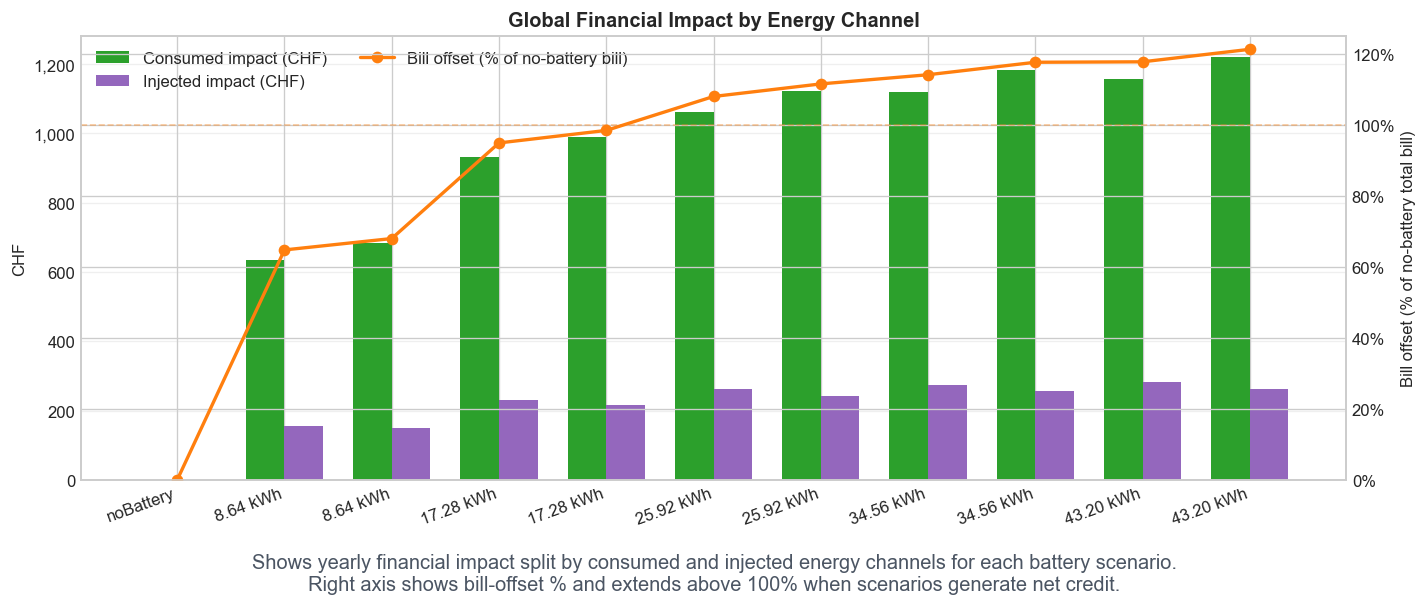

In [4]:
plot_df = df_global.copy()
x = np.arange(len(plot_df))
width = 0.36

# Optional override. Leave as None to auto-read from the no-battery JSON row.
# Example: 2000 means a 1,000 CHF total reduction is shown as 50%.
NO_BATTERY_TOTAL_BILL_CHF_OVERRIDE = None

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(
    x - width / 2,
    plot_df["consumed_impact_chf"],
    width,
    label="Consumed impact (CHF)",
    color="#2ca02c",
)
ax.bar(
    x + width / 2,
    plot_df["injected_impact_chf"],
    width,
    label="Injected impact (CHF)",
    color="#9467bd",
)

total_impact_chf = plot_df["consumed_impact_chf"] + plot_df["injected_impact_chf"]

ax.set_title("Global Financial Impact by Energy Channel")
ax.set_ylabel("CHF")
ax.set_xticks(x)
ax.set_xticklabels(plot_df["scenario_label"], rotation=20, ha="right")
ax.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:,.0f}"))
ax.grid(axis="y", alpha=0.3)

legend_handles, legend_labels = ax.get_legend_handles_labels()
no_battery_rows = plot_df[plot_df["total_kwh"] == 0]
auto_baseline_bill_chf = (
    float(no_battery_rows.iloc[0]["bill_without_battery_chf"])
    if not no_battery_rows.empty and pd.notna(no_battery_rows.iloc[0].get("bill_without_battery_chf", np.nan))
    else None
)
baseline_candidate = (
    NO_BATTERY_TOTAL_BILL_CHF_OVERRIDE
    if NO_BATTERY_TOTAL_BILL_CHF_OVERRIDE not in (None, "")
    else auto_baseline_bill_chf
)
baseline_for_pct = float(baseline_candidate) if baseline_candidate not in (None, 0, "") else None

if baseline_for_pct and baseline_for_pct > 0:
    bill_offset_pct = (total_impact_chf / baseline_for_pct) * 100.0
    ax2 = ax.twinx()
    ax2.plot(
        x,
        bill_offset_pct,
        color="#ff7f0e",
        marker="o",
        linewidth=2,
        label="Bill offset (% of no-battery bill)",
    )
    pct_max = float(np.nanmax(bill_offset_pct)) if len(bill_offset_pct) else 100.0
    pct_upper = max(100.0, np.ceil(pct_max / 25.0) * 25.0)
    ax2.set_ylim(0, pct_upper)
    ax2.set_ylabel("Bill offset (% of no-battery total bill)")
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:.0f}%"))
    ax2.axhline(100, color="#ff7f0e", linestyle="--", linewidth=1, alpha=0.4)

    # Annotate scenarios that become net-credit (negative bill).
    bill_with = plot_df.get("bill_with_battery_chf", pd.Series(np.nan, index=plot_df.index))
    for xi, pct, bill_chf in zip(x, bill_offset_pct, bill_with):
        if pd.notna(bill_chf) and bill_chf < 0:
            ax2.annotate(
                f"Net credit: {abs(bill_chf):.0f} CHF",
                (xi, min(pct, pct_upper)),
                textcoords="offset points",
                xytext=(0, -12),
                ha="center",
                fontsize=8,
                color="#b45309",
            )

    h2, l2 = ax2.get_legend_handles_labels()
    legend_handles += h2
    legend_labels += l2

ax.legend(legend_handles, legend_labels, frameon=False, ncol=2)

footnote = (
    "Shows yearly financial impact split by consumed and injected energy channels for each battery scenario.\n"
    "Right axis shows bill-offset % and extends above 100% when scenarios generate net credit."
)
if not baseline_for_pct:
    footnote += " Re-run simulations with billing fields (or set NO_BATTERY_TOTAL_BILL_CHF_OVERRIDE) to display the right-hand % axis."

fig.text(
    0.5,
    0.01,
    footnote,
    ha="center",
    fontsize=12,
    color="#4b5563",
    wrap=True,
)
plt.tight_layout(rect=[0, 0.08, 1, 1])
export_current_figure("02_global_energy_financial_impact_chf")
plt.show()


Saved figure: out/global_images/03_global_rentability_overview.png


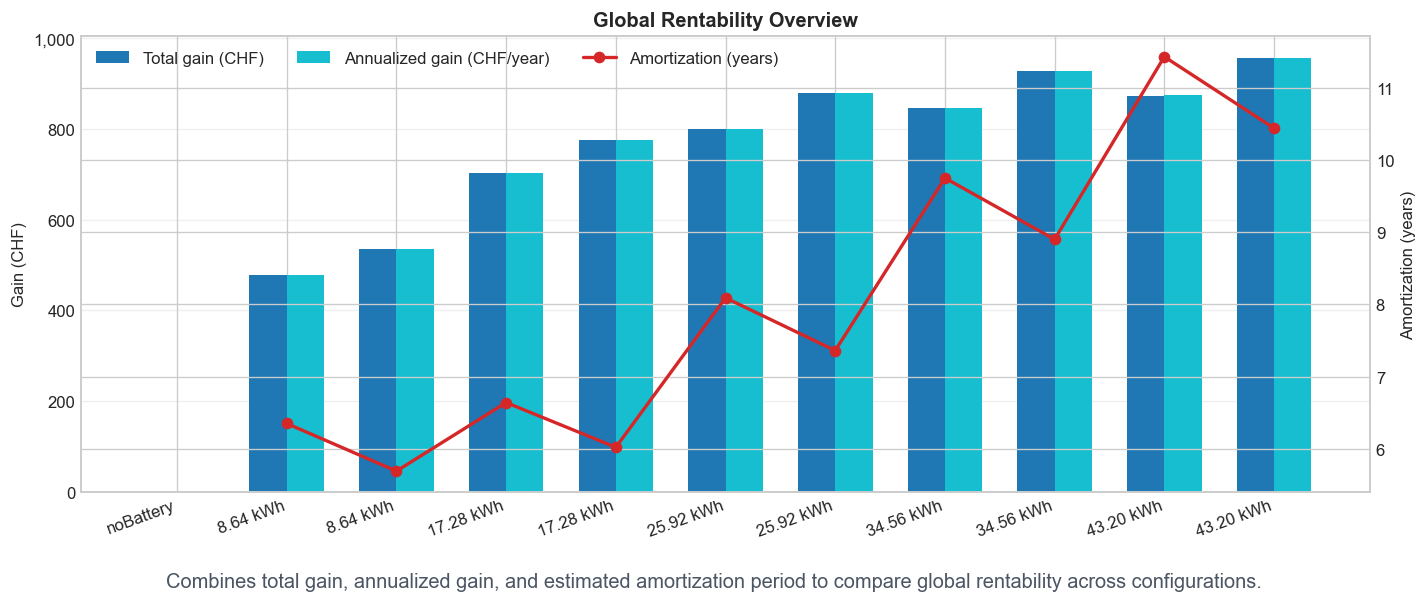

In [5]:
plot_df = df_global.copy()
x = np.arange(len(plot_df))
width = 0.34

fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.bar(
    x - width / 2,
    plot_df["total_gain_chf"],
    width,
    label="Total gain (CHF)",
    color="#1f77b4",
)
ax1.bar(
    x + width / 2,
    plot_df["annualized_gain_chf"],
    width,
    label="Annualized gain (CHF/year)",
    color="#17becf",
)
ax1.set_ylabel("Gain (CHF)")
ax1.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:,.0f}"))

ax2 = ax1.twinx()
ax2.plot(
    x,
    plot_df["amortization_years"],
    marker="o",
    linewidth=2,
    color="#d62728",
    label="Amortization (years)",
)
ax2.set_ylabel("Amortization (years)")

ax1.set_title("Global Rentability Overview")
ax1.set_xticks(x)
ax1.set_xticklabels(plot_df["scenario_label"], rotation=20, ha="right")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, frameon=False, ncol=3, loc="upper left")
ax1.grid(axis="y", alpha=0.3)

fig.text(
    0.5,
    0.01,
    "Combines total gain, annualized gain, and estimated amortization period to compare global rentability across configurations.",
    ha="center",
    fontsize=12,
    color="#4b5563",
    wrap=True,
)
plt.tight_layout(rect=[0, 0.06, 1, 1])
export_current_figure("03_global_rentability_overview")
plt.show()


Saved figure: out/global_images/04_global_battery_utilization.png


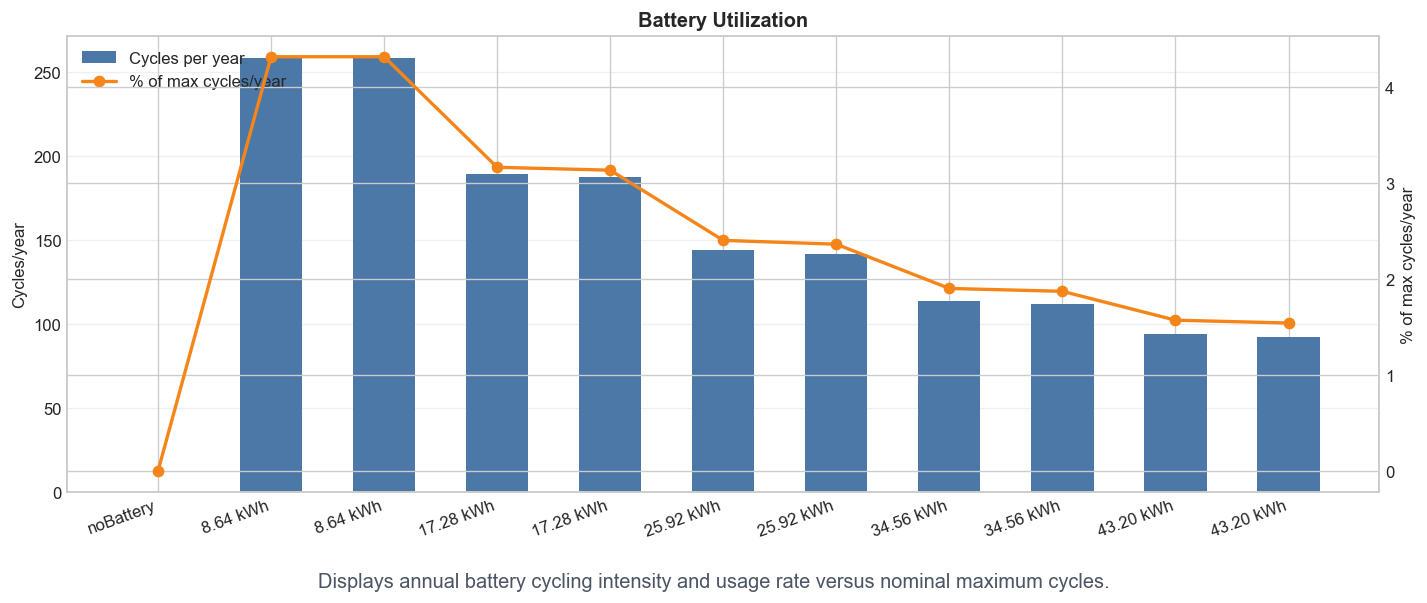

In [6]:
plot_df = df_global.copy()
x = np.arange(len(plot_df))

fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.bar(
    x,
    plot_df["cycles_per_year"],
    color="#4c78a8",
    width=0.55,
    label="Cycles per year",
)
ax1.set_ylabel("Cycles/year")
ax1.yaxis.set_major_formatter(FuncFormatter(lambda v, _: f"{v:,.0f}"))

ax2 = ax1.twinx()
ax2.plot(
    x,
    plot_df["pct_max_cycles"],
    marker="o",
    linewidth=2,
    color="#f58518",
    label="% of max cycles/year",
)
ax2.set_ylabel("% of max cycles/year")

ax1.set_title("Battery Utilization")
ax1.set_xticks(x)
ax1.set_xticklabels(plot_df["scenario_label"], rotation=20, ha="right")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, frameon=False, loc="upper left")
ax1.grid(axis="y", alpha=0.3)

fig.text(
    0.5,
    0.01,
    "Displays annual battery cycling intensity and usage rate versus nominal maximum cycles.",
    ha="center",
    fontsize=12,
    color="#4b5563",
    wrap=True,
)
plt.tight_layout(rect=[0, 0.06, 1, 1])
export_current_figure("04_global_battery_utilization")
plt.show()


Saved figure: out/global_images/05_global_battery_status_heatmap.png


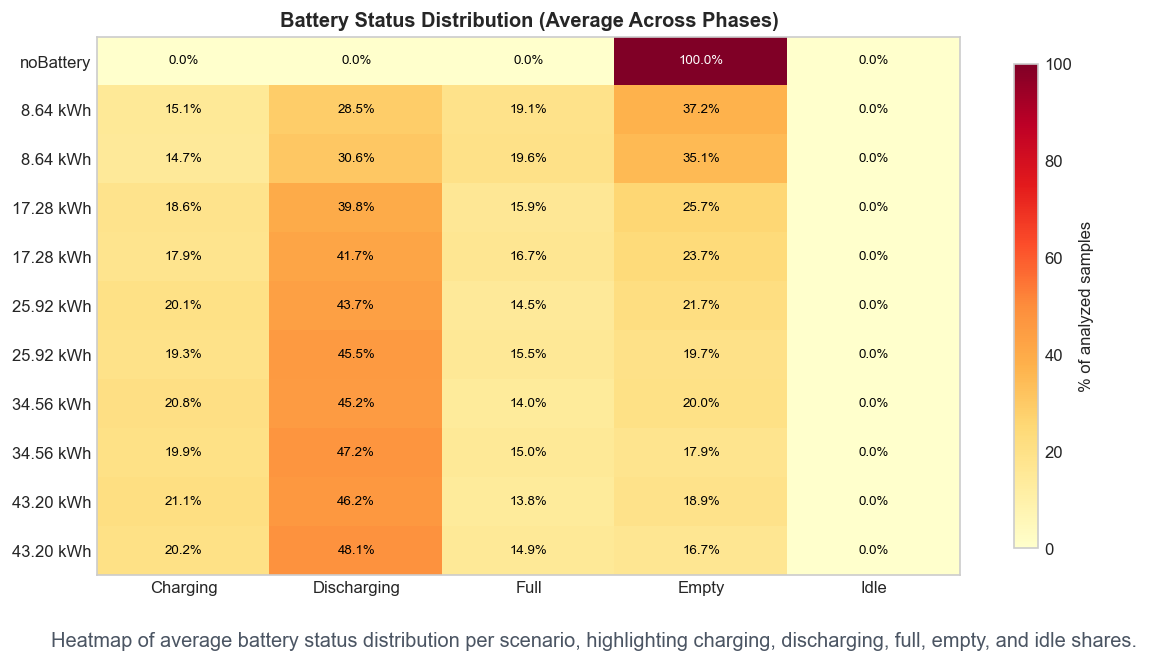

In [7]:
status_cols = [
    "status_charging_pct",
    "status_discharging_pct",
    "status_full_pct",
    "status_empty_pct",
    "status_idle_pct",
]
status_labels = ["Charging", "Discharging", "Full", "Empty", "Idle"]

plot_df = df_global.copy()
matrix = plot_df[status_cols].to_numpy()

fig, ax = plt.subplots(figsize=(10, 5.5))
im = ax.imshow(matrix, aspect="auto", cmap="YlOrRd", vmin=0, vmax=100)

ax.set_title("Battery Status Distribution (Average Across Phases)")
ax.set_xticks(np.arange(len(status_labels)))
ax.set_xticklabels(status_labels)
ax.set_yticks(np.arange(len(plot_df)))
ax.set_yticklabels(plot_df["scenario_label"])

for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        val = matrix[i, j]
        txt_color = "white" if val >= 55 else "black"
        ax.text(j, i, f"{val:.1f}%", ha="center", va="center", color=txt_color, fontsize=8)

cbar = fig.colorbar(im, ax=ax, shrink=0.9)
cbar.set_label("% of analyzed samples")

ax.grid(False)
fig.text(
    0.5,
    0.01,
    "Heatmap of average battery status distribution per scenario, highlighting charging, discharging, full, empty, and idle shares.",
    ha="center",
    fontsize=12,
    color="#4b5563",
    wrap=True,
)
plt.tight_layout(rect=[0, 0.06, 1, 1])
export_current_figure("05_global_battery_status_heatmap")
plt.show()
